# CTH Image Interpretation

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Step 1: Find the latest CTH file
base_url = "https://opendata.dwd.de/weather/satellite/clouds/CTH/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# List all .nc.bz2 files
cth_files = sorted([
    link.get("href") for link in soup.find_all("a")
    if link.get("href", "").endswith(".nc.bz2")
])

# Use the latest file
latest_file = cth_files[-1]
download_url = urljoin(base_url, latest_file)

# Download the file
filename = "cth_latest.nc.bz2"
with open(filename, "wb") as f:
    f.write(requests.get(download_url).content)

print(f"✅ Downloaded: {latest_file}")


✅ Downloaded: CTHin202504061445.nc.bz2


In [3]:
import netCDF4 as nc

ds = nc.Dataset("cth_latest.nc")

print("📦 Variables in file:")
for var in ds.variables:
    print(f" - {var}: {ds.variables[var].shape}")

📦 Variables in file:
 - lat: (934,)
 - lon: (1601,)
 - time: (1,)
 - CTH: (1, 934, 1601)
 - opa: (1, 934, 1601)
 - latlon: ()


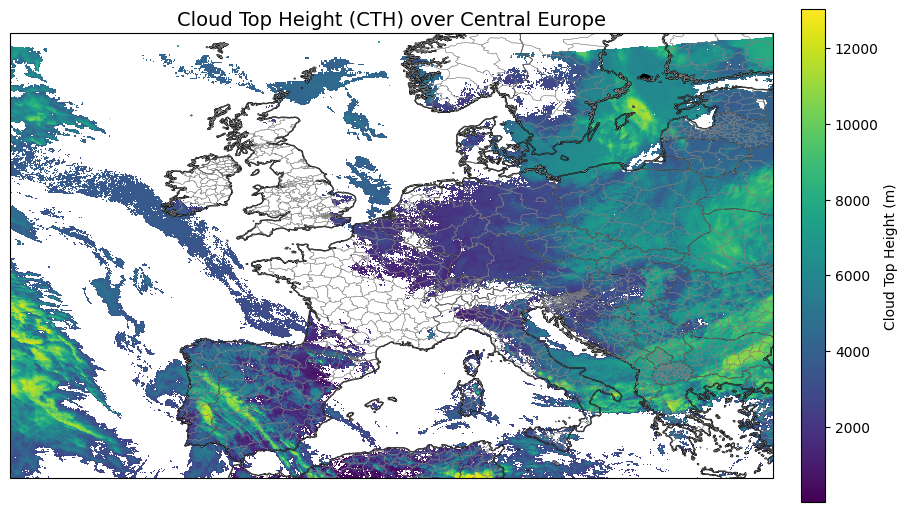

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Read variables
cth = ds.variables["CTH"][0, :, :]  # remove time dimension
lat = ds.variables["lat"][:]
lon = ds.variables["lon"][:]

# Optional: mask missing or invalid values
cth = np.ma.masked_where(cth <= 0, cth)

# Create meshgrid for pcolormesh
lon2d, lat2d = np.meshgrid(lon, lat)

# Set up map with Cartopy
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Plot data
mesh = ax.pcolormesh(lon2d, lat2d, cth, cmap="viridis", shading="auto", transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, orientation='vertical', pad=0.03, shrink=0.8)
cbar.set_label("Cloud Top Height (m)")

# Add features
ax.coastlines(resolution="10m", linewidth=1)
ax.add_feature(cfeature.BORDERS, linewidth=0.6)
ax.add_feature(cfeature.STATES.with_scale("10m"), linewidth=0.3, edgecolor="gray")

# Titles
plt.title("Cloud Top Height (CTH) over Central Europe", fontsize=14)

# Save and show
plt.savefig("cth_map.png", dpi=150, bbox_inches='tight')
plt.show()

In [11]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import base64
from IPython.display import Markdown, display

# Load API key from .env file
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Read and encode the image
with open("cth_map.png", "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

# Create the vision-enabled prompt
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                    "This is a satellite-derived Cloud Top Height (CTH) image over Europe."
                        "Please interpret the structure shown in the image: \n"
                        "- Identify regions of high or low cloud tops.\n"
                        "- Estimate where deep convection may be present.\n"
                        "- Describe what synoptic or convective features are visible.\n"
                        "- Provide a summary of the possible weather situation."
                    )
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=800,
)

# Display the response as markdown
interpretation = response.choices[0].message.content
display(Markdown(interpretation))

Based on the Cloud Top Height (CTH) image over Central Europe, here's an interpretation of the various meteorological aspects:

### Identification of Regions of High and Low Cloud Tops:

1. **High Cloud Tops**: 
   - Central Northern Europe, especially in the yellow-colored area over central Sweden and parts of Norway, displays very high cloud tops that exceed 10,000 meters. 
   - Some high cloud tops are also noticeable over the sea directly west of the Iberian peninsula.
  
2. **Low Cloud Tops**:
   - Major parts of the European mainland have lower cloud tops, particularly noticeable in France, Germany, and extending eastward across Poland into parts of Russia (indicated by purple to blue colors), where cloud tops range from 2000 to 6000 meters.

### Potential Areas of Deep Convection:

- The high cloud tops observed particularly in central parts of Scandinavia (central Sweden and nearby areas) are potential indicators of deep convective activity. Typically, cloud tops reaching or exceeding heights around 10,000 meters suggest the presence of cumulonimbus clouds, which are associated with heavy rainfall, thunderstorms, and potential severe weather events.

### Visible Synoptic or Convective Features:

- **An intense convective system** appears to be over Central Scandinavia, supported by the very high cloud tops as indicated by the yellow coloration. This system may suggest the development or presence of a strong weather front, potentially a cold front given its structure and scale.
- **Widespread lower cloud tops** across much of Western and Eastern Europe might be associated with stable weather patterns or widespread stratiform clouds usually seen with settled conditions or behind a front.

### Possible Summary of the Weather Situation:

- The presence of high, deep convective cloud tops over Central Scandinavia suggests ongoing or developing strong weather activities, likely associated with significant rainfall, thunderstorms, or possibly snow if temperatures are low enough.
- In contrast, much of the rest of the Central European region, characterized by lower cloud tops, might be experiencing more stable and milder weather. This could manifest as cloudy but largely dry conditions, potentially following the passage of a weather front.
- The contrasting cloud top heights from the west to the east may indicate a strong weather gradient, potentially impacting weather conditions rapidly over short distances in the region.

In conclusion, the satellite-derived CTH image suggests significant weather activity, particularly over Scandinavia, with potential impacts including precipitation and more pronounced weather events, while a quieter weather regime may prevail over large parts of Western and Central Europe.